# Three Body Problem: Neural Network Training

A simple neural network is trained to learn approximate solutions to the three body problem.<br>
Data is sampled from three body systems with parameters similar to planets in the solar system.

In [ ]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

In [ ]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style, range_inc
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly, G_
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from jacobi import CartesianToJacobi, JacobiToCartesian

from g3b_data import make_traj_g3b, make_data_g3b, make_datasets_g3b, traj_to_batch
from g3b_data import make_datasets_solar, make_datasets_hard
from g3b_data import combine_datasets_g3b, combine_datasets_solar
from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
from g3b import KineticEnergy_G3B, PotentialEnergy_G3B, Momentum_G3B, AngularMomentum_G3B
from g3b import VectorError, EnergyError
from g3b import Motion_G3B, make_physics_model_g3b
from g3b import fit_model
from g3b_model_math import make_position_model_g3b_math, make_model_g3b_math
from g3b_model_nn import make_position_model_g3b_nn, make_model_g3b_nn

In [ ]:
# Set active GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[1:2], 'GPU')

In [ ]:
# Grow GPU memory (must be first operation in TF)
# gpu_grow_memory()

In [ ]:
# Lightweight serialization
fname = '../data/g3b/g3b_train.pickle'
vartbl = load_vartbl(fname)

In [ ]:
# Set plot style
plot_style()

In [ ]:
# Description of datasets to be loaded
n_years = 100
sample_freq = 10
traj_size = n_years * sample_freq + 1

In [ ]:
# Configuration for loading data sets
# num_data_sets = 50
num_data_sets = 5
batch_size = 256
# num_gpus = 1
# full_batch_size = num_gpus * batch_size
seed0 = 42

In [ ]:
# Create a tiny data set with 64 solar type orbits
n_traj_tiny = 64
ds_tiny_trn, ds_tiny_val, ds_tiny_tst = make_datasets_solar(n_traj=n_traj_tiny, vt_split=1.0, 
                                                            n_years=n_years, sample_freq=sample_freq)

In [ ]:
# Build combined solar data sets
ds_trn, ds_val, ds_tst = combine_datasets_solar(num_data_sets=num_data_sets, batch_size=batch_size, seed0=seed0)

### Create the Math Model as a Benchmark

In [ ]:
model_math = make_model_g3b_math(traj_size=traj_size)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'P': VectorError(name='P_loss', regularizer=1.0),
        'L': VectorError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0E4,
                'v0_rec': 1.0E4,
                'H': 1.0,
                'P': 1.0,
                'L': 1.0}

In [ ]:
# Compile the full mathematical model
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

### Train the Neural Network Model

In [ ]:
# Configuration for neural network model architecture
# hidden_sizes = [64, 16]
hidden_sizes = []
skip_layers = True
traj_size = 1001

# Training configuration
reg = 1.0E2
kernel_reg = reg
activity_reg = reg
learning_rate = 1.0E-4

In [ ]:
# Build neural network model
model_nn = make_model_g3b_nn(hidden_sizes=hidden_sizes, skip_layers=skip_layers, 
                             kernel_reg=kernel_reg, activity_reg=activity_reg,
                             traj_size=traj_size, batch_size=batch_size)

In [ ]:
# model_nn.summary()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
# optimizer = keras.optimizers.Adadelta()

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0E-2, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'P': VectorError(name='P_loss', regularizer=1.0E-6),
        'L': VectorError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0E4,
                'v0_rec': 1.0E4,
                'H': 1.0,
                'P': 1.0,
                'L': 1.0}

In [ ]:
# Compile the NN model
model_nn.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# Evaluate the NN model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Compare this to math model - should be the same before training
# model_math.evaluate(ds_val)

# Hard coded baseline losses
loss_baseline_list = \
[0.01564649583971394,
 0.0051587406,
 0.0053154626,
 0.005172265,
 3.3106947e-14,
 3.2552384e-14,
 2.5221508e-08,
 1.1691268e-14,
 2.1020908e-14]

# Baseline position loss
q_loss_baseline = loss_baseline_list[1]

# Table of baseline losses
keys = ['loss', 'q_loss', 'v_loss', 'a_loss', 'q0_rec_loss', 'v0_rec_loss', 'H_loss', 'P_loss', 'L_loss']
loss_baseline = {key: loss_baseline_list[i] for i, key in enumerate(keys)}
# Set dummy batch_num and time
loss_baseline['batch_num'] = 0
loss_baseline['time'] = 0.0

# Initialize history before training
hist0 = {key: np.array([val], dtype=np.float32) for key, val in loss_baseline.items()}

# Review baseline loss table
# loss_baseline

In [ ]:
# Set up training
suffix = '_'.join(str(sz) for sz in hidden_sizes)
model_name = f'model_g3b_nn_{suffix}'
model_h5 = f'../models/g3b/{model_name}.h5'
hist_name = model_name.replace('model_', 'hist_')
epochs = 1
save_freq = 'epoch'

In [ ]:
# Attempt to load model or train a single epoch
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = fit_model(model=model_nn, 
                     ds=ds_trn, 
                     epochs=epochs,
                     save_freq=save_freq,
                     prev_history = hist0, 
                     batch_num=1)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# num_epochs = 50
num_epochs = 1
for i in range_inc(1, num_epochs):
    ts = datetime.datetime.now()
    st = ts.strftime('%Y-%m-%d %H:%M:%S')
    print(f'*** Training loop {i:3} *** - {st}')
    hist = fit_model(model=model_nn, 
                     ds=ds_trn, 
                     epochs=epochs,
                     loss=loss, 
                     optimizer=optimizer,
                     metrics=metrics,
                     save_freq=save_freq,
                     prev_history = hist, 
                     batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='q_loss', baseline=q_loss_baseline)

In [ ]:
# Plot the total loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='loss')

In [ ]:
hist

In [ ]:
# Evaluate the trained model on the training data
# model_nn.evaluate(ds_trn)

In [ ]:
# Evaluate the trained model on the test data
# model_nn.evaluate(ds_tst)

## Perturbed Sun-Earth-Jupiter System

In [26]:
from sej_data import load_data_sej, make_datasets_sej, combine_datasets_sej
import numpy as np
from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
import matplotlib.pyplot as plt

In [12]:
# Trajectory length
n_years = 100
sample_freq = 10

# Number of trajectories
num_batches = 1
n_traj = 100
vt_split = 0.20
batch_size = 64

In [13]:
# Orbital perturbation scales
sd_log_a = 0.01
sd_log_e = 0.10
sd_log_inc = 0.10
sd_Omega = np.pi * 0.02
sd_omega = np.pi * 0.02
sd_f = np.pi * 0.02

In [14]:
# List of seeds to use for datasets
seed0 = 42
seed1 = seed0 + num_batches * 3
seeds = list(range(seed0, seed1, 3))

In [15]:
data = load_data_sej(n_traj=n_traj, vt_split=vt_split, n_years=n_years, sample_freq=sample_freq,
                     sd_log_a=sd_log_a, sd_log_e=sd_log_e, sd_log_inc=sd_log_inc,
                     sd_Omega=sd_Omega, sd_omega=sd_omega, sd_f=sd_f, seed=seed0)

Loaded data from ../data/sej/1845708695.pickle.


In [21]:
inputs_trn, outputs_trn = data[0:2]

data_trn = {**inputs_trn, **outputs_trn}

In [27]:
inputs_trn['t'].shape

(100, 1001)

In [25]:
outputs_trn['q'].shape

(100, 1001, 3, 3)

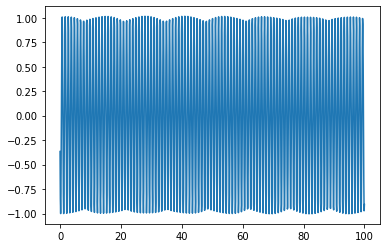

In [31]:
plt.plot(inputs_trn['t'][0], outputs_trn['q'][0][:, 1, 0])

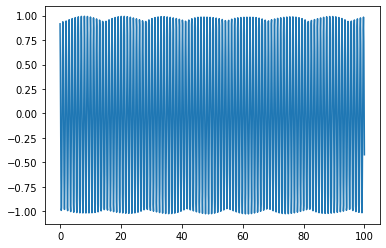

In [34]:
plt.plot(inputs_trn['t'][0], outputs_trn['q'][0][:, 1, 1])

In [37]:
np.mean(outputs_trn['orb_a'], axis=(0))

array([[0.99887747, 5.206242  ],
       [0.9988757 , 5.206242  ],
       [0.9988855 , 5.206242  ],
       ...,
       [0.99888456, 5.206242  ],
       [0.9988864 , 5.206242  ],
       [0.99888796, 5.206242  ]], dtype=float32)

In [38]:
outputs_trn['orb_a'].shape

(100, 1001, 2)

In [41]:
np.mean(outputs_trn['orb_a'][:, 0, :], axis=0)

array([0.99887747, 5.206242  ], dtype=float32)

In [42]:
np.std(outputs_trn['orb_a'][:, 0, :], axis=0)

array([0.00850855, 0.05179359], dtype=float32)

In [43]:
np.mean(outputs_trn['orb_e'][:, 0, :], axis=0)

array([0.01700814, 0.04919723], dtype=float32)

In [44]:
np.std(outputs_trn['orb_e'][:, 0, :], axis=0)

array([0.0017482 , 0.00473943], dtype=float32)